# Wojciech Kosiuk Homework 2

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd

### Loading Data CIFAR 10

In [ ]:
batch_size = 4
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2) 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

A few basic images:

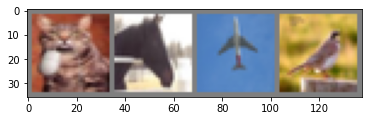

cat   horse plane bird 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np



def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Defining ResNet18 and ResNet34

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [ ]:

trainset1, trainset2 = torch.utils.data.random_split(trainset, [20000, 30000])

trainloader1 = torch.utils.data.DataLoader(trainset1, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Training ResNet18 on subset 1/3 (20k rows) and testing on the test sample

In [ ]:
net = ResNet18()
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(8):  

    running_loss = 0.0
    for i, data in enumerate(trainloader1, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.938
[1,  4000] loss: 1.614
[2,  2000] loss: 1.306
[2,  4000] loss: 1.199
[3,  2000] loss: 1.007
[3,  4000] loss: 0.982
[4,  2000] loss: 0.802
[4,  4000] loss: 0.807
[5,  2000] loss: 0.651
[5,  4000] loss: 0.672
[6,  2000] loss: 0.512
[6,  4000] loss: 0.569
[7,  2000] loss: 0.406
[7,  4000] loss: 0.454
[8,  2000] loss: 0.302
[8,  4000] loss: 0.357
Finished Training


### Accuracy of the model (overall and among the classes)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 70 %


In [ ]:

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 74.6 %
Accuracy for class: car   is 86.3 %
Accuracy for class: bird  is 58.4 %
Accuracy for class: cat   is 67.8 %
Accuracy for class: deer  is 58.6 %
Accuracy for class: dog   is 48.3 %
Accuracy for class: frog  is 69.0 %
Accuracy for class: horse is 76.9 %
Accuracy for class: ship  is 84.6 %
Accuracy for class: truck is 79.5 %


### Confusion Matrix

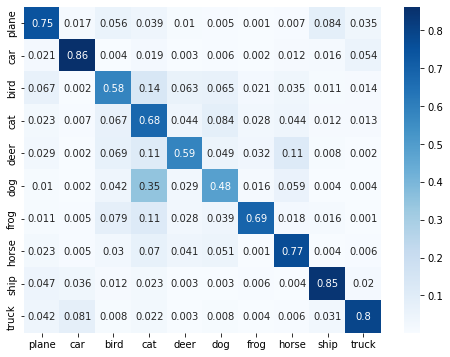

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for data in testloader:
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        output = net(inputs.float())

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### Images that were badly predicted by the model

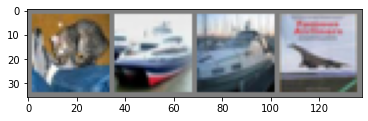

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   dog   car   horse


## Training ResNet34 on subset 1/3 (20k rows) and testing on the test sample

In [ ]:
net2 = ResNet34()
net2.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)


for epoch in range(8): 
    running_loss = 0.0
    for i, data in enumerate(trainloader1, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.052
[1,  4000] loss: 1.740
[2,  2000] loss: 1.434
[2,  4000] loss: 1.293
[3,  2000] loss: 1.077
[3,  4000] loss: 1.041
[4,  2000] loss: 0.884
[4,  4000] loss: 0.857
[5,  2000] loss: 0.690
[5,  4000] loss: 0.725
[6,  2000] loss: 0.563
[6,  4000] loss: 0.608
[7,  2000] loss: 0.434
[7,  4000] loss: 0.501
[8,  2000] loss: 0.353
[8,  4000] loss: 0.414
Finished Training


### Accuracy of the model (overall and among the classes)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %


In [ ]:

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net2(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 72.5 %
Accuracy for class: car   is 90.4 %
Accuracy for class: bird  is 61.4 %
Accuracy for class: cat   is 67.2 %
Accuracy for class: deer  is 73.2 %
Accuracy for class: dog   is 43.8 %
Accuracy for class: frog  is 65.8 %
Accuracy for class: horse is 79.9 %
Accuracy for class: ship  is 79.8 %
Accuracy for class: truck is 82.9 %


### Confusion Matrix

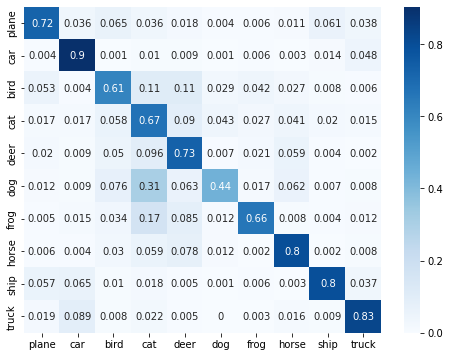

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for data in testloader:
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        output = net2(inputs.float()) 

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### Images that were badly predicted by the model

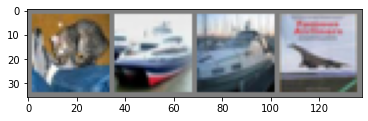

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   dog   car   horse


## Comparing ResNet18 and ResNet34 

In [ ]:
loss_array18_8 = [ 1.933, 1.672, 1.349, 1.228, 1.018, 0.983, 0.820, 0.810, 0.646, 0.689, 0.513, 0.572, 0.397, 0.444, 0.296, 0.348]
loss_array34_8 = [ 2.052, 1.740, 1.434, 1.293, 1.077, 1.041, 0.884, 0.857, 0.690, 0.725, 0.563, 0.608, 0.434, 0.501, 0.353, 0.414]

In [ ]:
import matplotlib.pyplot as plt

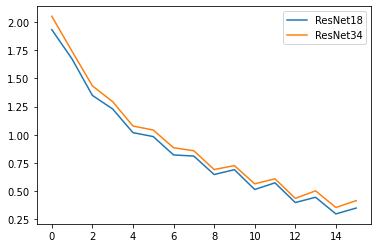

In [ ]:
plt.plot(loss_array18_8)
plt.plot(loss_array34_8)
plt.legend(['ResNet18','ResNet34'])

For most of the classes ResNet34's accuracy is slightly higher. Only classes with higher accuracy in ResNet18 than in ResNet34 are plane and ship. The highest advantage of ResNet34 occurs in class deer where accuracy of ResNet18 is 59% and accuracy of ResNet34 - 73%. However, the overall difference in accuracy between two networks is insignificant.

## Comparing Multiple Learning Rates on ResNet18

In [ ]:
import torch.optim as optim

def TrainNetCIFAR(net,n,learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
  
  loss_array = []

  for epoch in range(n): 

    running_loss = 0.0
    for i, data in enumerate(trainloader1, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            loss_array.append(running_loss / 2000)
            running_loss = 0.0

  print('Finished Training')
  return loss_array

In [ ]:
learning_rates = [0.001,0.01,0.1,0.5,1]
running_loss = []

for lr in learning_rates:
  net3 = ResNet18()
  net3.to(device)
  running_loss.append(TrainNetCIFAR(net3,4,lr))

running_loss

Finished Training
Finished Training
Finished Training
Finished Training
Finished Training


[[1.9482301004529,
  1.6617537087798118,
  1.330212116971612,
  1.2365118668079376,
  1.0140457277912647,
  0.9786401267694309,
  0.7874002456236631,
  0.8194047304959968],
 [2.154034416258335,
  1.8344177704155444,
  1.6088972690552472,
  1.4900755181014538,
  1.245437812410295,
  1.1659721918851138,
  0.9683727645194158,
  0.9404279269874096],
 [2.3480525362491607,
  2.1515318384766577,
  1.9133975399285554,
  1.7939641680419445,
  1.6479673473984002,
  1.5954579214155673,
  1.4699049246236682,
  1.4299049191996456],
 [2.6988917271494866,
  2.5958323007822037,
  2.62221236371994,
  2.613403872668743,
  2.595565768420696,
  2.6174107039570806,
  2.6022679684162138,
  2.596389256119728],
 [3.1135988699793815,
  2.979931310072541,
  2.976277232885361,
  2.962263777554035,
  2.9695305184721947,
  3.011216472327709,
  2.993876472711563,
  2.9925353679060938]]

Text(0.5, 1.0, 'Comparison of Learning Rates')

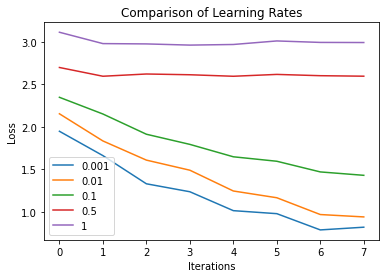

In [ ]:
import matplotlib.pyplot as plt

for rl in running_loss:
  plt.plot(rl)

plt.legend(['0.001','0.01','0.1','0.5','1'])
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Comparison of Learning Rates")


The lower the learning rate, the lower mean loss function is. This plot shows that using lower learning rates gives far better results. However, there is little diference between learing rates 0.001 and 0.01. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
width = 4000
height = 3000
max_dim = 100
full_image = Image.new('RGB', (width, height))
for idx, x in enumerate(x_test):
    tile = Image.fromarray(np.uint8(x * 255))
    rs = max(1, tile.width / max_dim, tile.height / max_dim)
    tile = tile.resize((int(tile.width / rs),
                        int(tile.height / rs)),
                       Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim) * tx[idx]),
                            int((height-max_dim) * ty[idx])))

## OxfordIIITPet

Due to the inability to load data from a function in torchvision.datasets, all the images come from the dataset downloaded from the official site of the dataset.

In [ ]:
import tarfile
  
# open file
file = tarfile.open('/content/annotations.tar.gz')
file.extractall('/content')
file.close()
file2 = tarfile.open('/content/images.tar.gz')
file2.extractall('/content')
file2.close()

In [ ]:
from glob import glob
from PIL import Image
from torchvision.datasets import ImageFolder

In [ ]:
filenames = glob('images/*.jpg')

In [ ]:
def load_image(filename) :
    img = Image.open(filename)
    img = img.convert('RGB')
    return img

In [ ]:
classes = set()

data = []
labels = []

for image in filenames:
    class_name = image.rsplit("/", 1)[1].rsplit('_', 1)[0]
    classes.add(class_name)
   
    try:
      img = load_image(image)

      data.append(img)
      labels.append(class_name)
      
    except OSError as error : 
      print("File descriptor is not associated with any terminal device") 
      continue


File descriptor is not associated with any terminal device


In [ ]:
len(classes)

37

One photo is bugged so I will not use it.

In [ ]:
class2idx = {cl: idx for idx, cl in enumerate(classes)}        
labels = torch.Tensor(list(map(lambda x: class2idx[x], labels))).long()

data = list(zip(data, labels))

In [ ]:
from sklearn.model_selection import train_test_split

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [ ]:
from torch.utils.data.dataset import Dataset
class PetDataset(Dataset):
    
    def __init__(self, data, transforms=None):
        self.data = data
        self.len = len(data)
        self.transforms = transforms
    
    def __getitem__(self, index):
        img, label = self.data[index]
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, label
    
    def __len__(self):
        return self.len

In [ ]:
train_data, val_data = train_test_split(data,test_size=0.3, random_state=42)

In [ ]:
train_ds = PetDataset(train_data, transforms=train_transforms)
val_ds = PetDataset(val_data, transforms=val_transforms)

In [195]:
from torch.utils.data import DataLoader, SubsetRandomSampler
train_indices = list(range(len(train_ds)))
test_indices = list(range(len(val_ds)))

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(train_ds, batch_size=4, sampler=train_sampler, shuffle=False, num_workers=2)
test_loader = DataLoader(val_ds, batch_size=4, sampler=test_sampler, shuffle=False, num_workers=2)

In [198]:
len(train_indices),len(test_indices)

(147, 63)

In [ ]:
dataiter = iter(train_loader)
i, data1 = dataiter.next()
data1[0]

tensor(22)

In [182]:
class ResNetOxford(nn.Module):
    def __init__(self, block, num_blocks, num_classes=37):
        super(ResNetOxford, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [183]:
def ResNet18Oxford():
  return ResNetOxford(BasicBlock, [2, 2, 2, 2])

In [204]:
net5 = ResNet18Oxford()
net5.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net5.parameters(), lr=0.001, momentum=0.9)

running_losses = []

for epoch in range(128):  

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        m = nn.AdaptiveAvgPool2d(32)
        inputs = m(inputs)
        optimizer.zero_grad()

        outputs = net5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 35 == 34:   
            running_losses.append(running_loss)
            running_loss = 0.0

print('Finished Training')

Finished Training


In [212]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        m = nn.AdaptiveAvgPool2d(32)
        images = m(images)
        outputs = net5(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 7 %


Text(0.5, 1.0, 'Loss function in the process of learning')

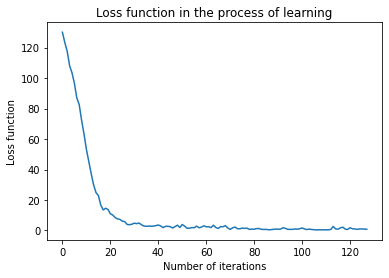

In [211]:
plt.plot(running_losses)
plt.xlabel("Number of iterations")
plt.ylabel("Loss function")
plt.title("Loss function in the process of learning")

Little data (only 210 images) made a model unable to learn efficiently. Accuracy achieved after 128 epochs is only 7% which is only twice better than random choosing. However, if given more data, the model would probably be quite efficient. 